In [82]:
#Importing libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import requests
pd.options.mode.chained_assignment = None
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from datetime import datetime
from wordcloud import WordCloud,STOPWORDS
import sqlite3
import pandas as pd
from bs4 import BeautifulSoup
import os
from sklearn.model_selection import train_test_split
from gensim.models import Doc2Vec
import gensim
from gensim.models.doc2vec import TaggedDocument
import multiprocessing
from sklearn import utils


In [83]:
# Connect to SQLite database
conn = sqlite3.connect('reddit_data.db')

# Query to select all data from the reddit_posts table
query = "SELECT * FROM reddit_posts"

# Read data from the database into a DataFrame
data = pd.read_sql_query(query, conn)

# Close connection
conn.close()

# Display the DataFrame
data.head()

,id,subreddit,title,selftext,upvote_ratio,ups,downs,score,link_flair_css_class,created_utc,kind,cleaned
0,1,politics,Trump Jokes About How Longtime Aide Could End ...,,1.00,3,0,3,None,2024-04-12T09:54:31Z,t3,None
1,2,politics,US to probe if Chinese cars pose national data...,,1.00,4,0,4,None,2024-04-12T09:41:11Z,t3,None
2,3,politics,Irish taoiseach and Spanish PM to discuss Pale...,,0.54,1,0,1,None,2024-04-12T09:09:41Z,t3,None
3,4,politics,Why Trump’s ‘hush money’ case is bigger than h...,,0.94,15,0,15,None,2024-04-12T09:01:51Z,t3,None
4,5,politics,1864 AZ Speaker of the house who helped pass t...,,0.86,35,0,35,None,2024-04-12T08:20:41Z,t3,None


In [84]:
data.shape

(993, 12)

In [85]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 993 entries, 0 to 992
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    993 non-null    int64  
 1   subreddit             993 non-null    object 
 2   title                 993 non-null    object 
 3   selftext              993 non-null    object 
 4   upvote_ratio          993 non-null    float64
 5   ups                   993 non-null    int64  
 6   downs                 993 non-null    int64  
 7   score                 993 non-null    int64  
 8   link_flair_css_class  7 non-null      object 
 9   created_utc           993 non-null    object 
 10  kind                  993 non-null    object 
 11  cleaned               0 non-null      object 
dtypes: float64(1), int64(4), object(7)
memory usage: 93.2+ KB


In [86]:
data.selftext

0       
1       
2       
3       
4       
      ..
988     
989     
990     
991     
992     
Name: selftext, Length: 993, dtype: object

I extracted the text from the 'title' column of the data and used the WordCloud library to generate the word cloud. 

In [87]:
# plt.figure(figsize=(60,35))
# #subset = data['title']
# text = data['selftext'].values
# cloud1=WordCloud(stopwords=STOPWORDS,background_color='pink',colormap="Dark2",collocations=False,width=2500,height=1800).generate(" ".join(text))
# plt.axis('off')
# plt.title("r/politics",fontsize=40)
# plt.imshow(cloud1)

As we can see from the word cloud, the main themes are around recent developments relating to Abortion, bans and Arizona, mostly US politics heavy.

In [88]:
import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
from nltk.corpus import stopwords
from string import punctuation

# stop = set(stopwords.words('english'))

In [89]:
stop = set(STOPWORDS)

In [90]:
import re

def lower(text):
    return text.lower()

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop])

def remove_punctuation(text):
    return text.translate(str.maketrans('','', punctuation))

def clean_text(text):
    text = lower(text)
    text = remove_stopwords(text)
    text = remove_punctuation(text)
    return text

#Apply function on column
data['cleaned']=data['title'].apply(clean_text)

In [91]:
data['cleaned'].head()

0           trump jokes longtime aide end career flash
1    us probe chinese cars pose national data secur...
2    irish taoiseach spanish pm discuss palestine n...
3          trump’s ‘hush money’ case bigger hush money
4    1864 az speaker house helped pass abortion law...
Name: cleaned, dtype: object

In [10]:
from collections import Counter
cnt=Counter()

for text in data['cleaned'].values:
    for word in text.split():
        cnt[word]+=1
        
cnt.most_common(10)

[('trump', 245),
 ('biden', 154),
 ('abortion', 97),
 ('says', 94),
 ('us', 80),
 ('new', 60),
 ('donald', 52),
 ('election', 52),
 ('trump’s', 49),
 ('house', 49)]

In [11]:
FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
def remove_freqwords(text):
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

data['cleaned'] = data['cleaned'].apply(lambda text: remove_freqwords(text))

In [ ]:
data['cleaned'].head()

0                 jokes longtime aide end career flash
1    probe chinese cars pose national data security...
2    irish taoiseach spanish pm discuss palestine n...
3                  ‘hush money’ case bigger hush money
4    1864 az speaker helped pass law 5 very young w...
Name: cleaned, dtype: object

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, # sublinear TF scaling to scale term frequencies logarithmically to reduce the importance of very frequent terms
                        ngram_range=(1, 2), 
                        stop_words='english')

features = tfidf.fit_transform(data.cleaned).toarray()


print("Each of the %d cleaned text is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 993 cleaned text is represented by 375 features (TF-IDF score of unigrams and bigrams)


In [ ]:
features.shape 

(993, 2811)

# Sentiment Analysis

### With AFINN Lexicon


In [13]:
# initialize afinn sentiment analyzer
from afinn import Afinn
af = Afinn()

In [14]:
# compute sentiment scores (polarity) and labels
data['sentiment_score'] = data['cleaned'].apply(lambda x: af.score(x))
# data['sentiment_score']

In [15]:
# Add a column 'sentiment_category' based on 'sentiment_score'
data['sentiment_category'] = data['sentiment_score'].apply(lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral'))
# data['sentiment_category']

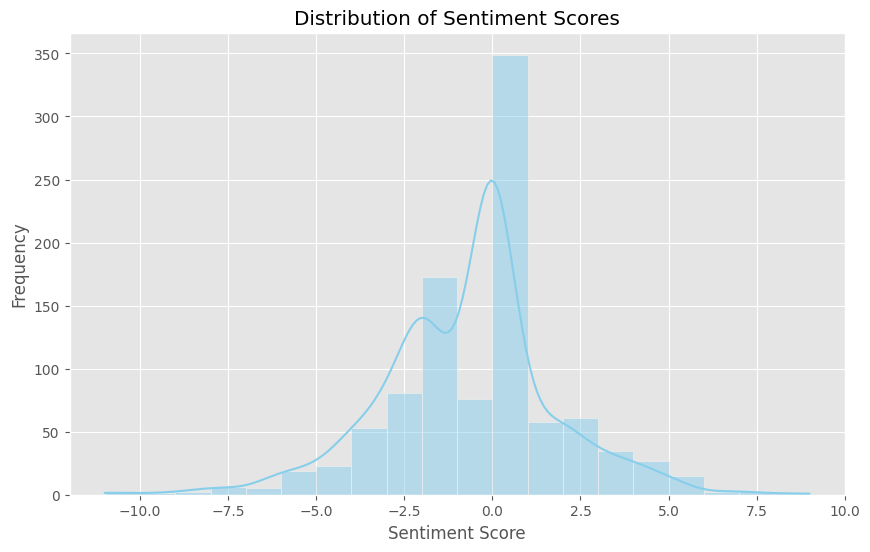

In [16]:
# Plot distribution of sentiment scores
plt.figure(figsize=(10, 6))
sns.histplot(data['sentiment_score'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

In [17]:
sentiment_counts = data['sentiment_category'].value_counts()


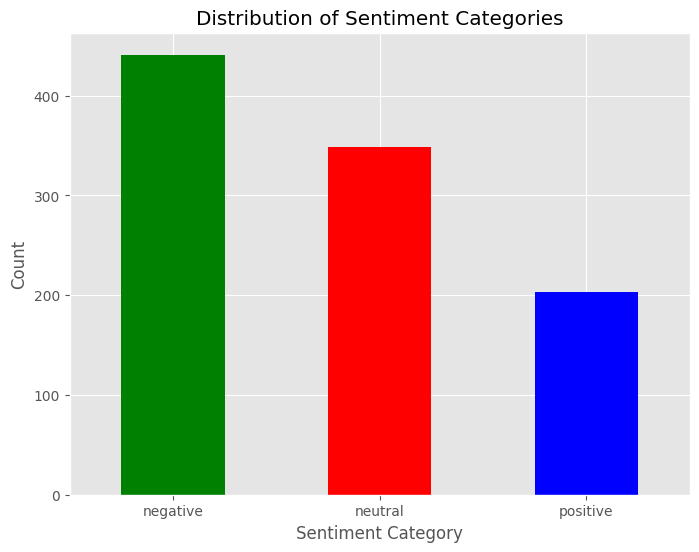

In [18]:
# Plot distribution of sentiment categories
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['green', 'red', 'blue'])
plt.title('Distribution of Sentiment Categories')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.show()

In [ ]:
sorted = data.sort_values(by='sentiment_score')
#sorted['cleaned'].head()

In [ ]:
#pd.set_option('display.max_colwidth', None)
# print(sorted['post'].head())

In [ ]:
#print(sorted['post'].tail(2))

### With TextBlob

In [19]:
from textblob import TextBlob


In [ ]:
#data['post']

In [20]:
# compute sentiment scores (polarity) and labels
data['sentiment_score_tb'] = data['cleaned'].apply(lambda x: round(TextBlob(x).sentiment.polarity, 3))
#data['sentiment_score_tb']

#sentiment_scores_tb = [round(TextBlob(article).sentiment.polarity, 3) for article in news_df['clean_text']]


In [21]:
# Add a column 'sentiment_category' based on 'sentiment_score'
data['sentiment_category_tb'] = data['sentiment_score_tb'].apply(lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral'))
#data['sentiment_category_tb']

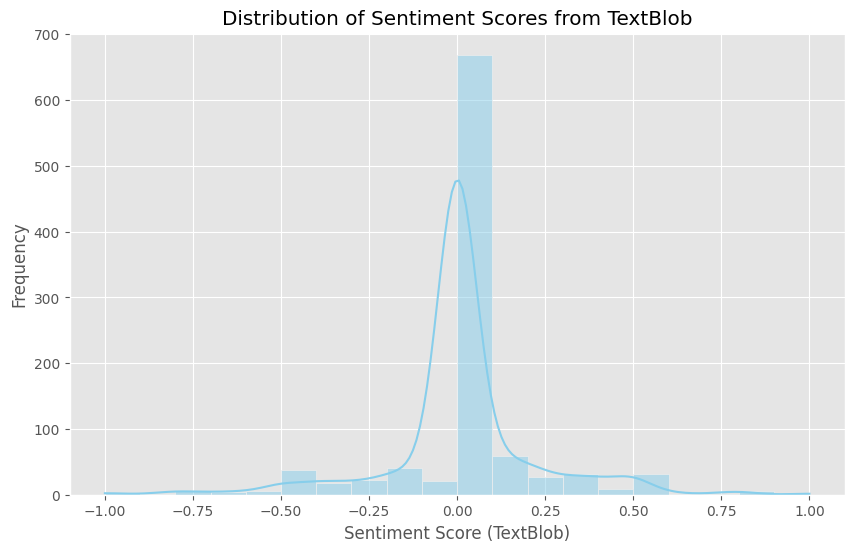

In [22]:
# Plot distribution of sentiment scores
plt.figure(figsize=(10, 6))
sns.histplot(data['sentiment_score_tb'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Sentiment Scores from TextBlob')
plt.xlabel('Sentiment Score (TextBlob)')
plt.ylabel('Frequency')
plt.show()

In [23]:
sentiment_counts_tb = data['sentiment_category_tb'].value_counts()


In [24]:
sentiment_counts_tb

neutral     611
positive    224
negative    158
Name: sentiment_category_tb, dtype: int64

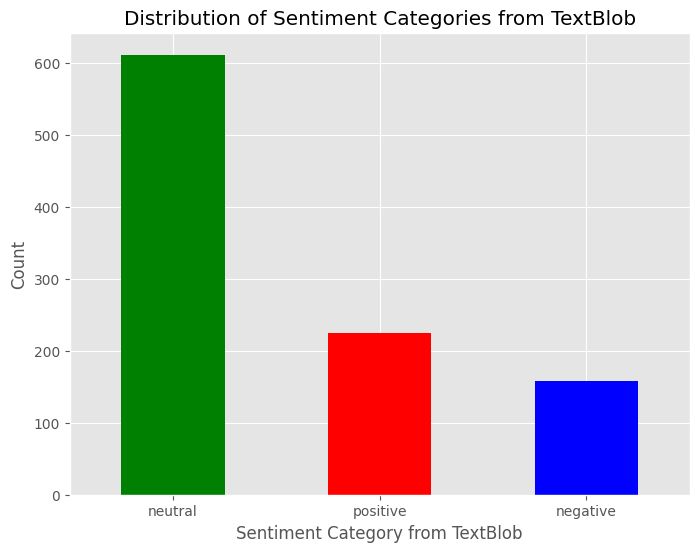

In [25]:
# Plot distribution of sentiment categories
plt.figure(figsize=(8, 6))
sentiment_counts_tb.plot(kind='bar', color=['green', 'red', 'blue'])
plt.title('Distribution of Sentiment Categories from TextBlob')
plt.xlabel('Sentiment Category from TextBlob')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.show()

In [ ]:
sorted_tb = data.sort_values(by='sentiment_score_tb')
# sorted_tb['cleaned'].head()

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
 

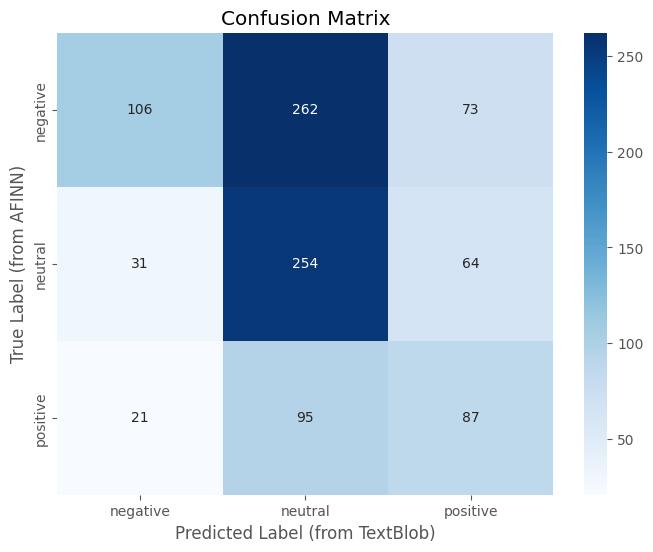

In [27]:
# True labels (ground truth)
true_labels = data['sentiment_category']

# Predicted labels
predicted_labels = data['sentiment_category_tb']  

# Define the list of classes
classes = ['negative', 'neutral', 'positive']

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label (from TextBlob)')
plt.ylabel('True Label (from AFINN)')
plt.show()

### With VADER

In [28]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

In [29]:
sia = SentimentIntensityAnalyzer()

In [30]:
res = {}
for i, row in tqdm(data.iterrows(), total=len(data)):
    text = row['cleaned']
    myid = row['id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/993 [00:00<?, ?it/s]

In [ ]:
res

{1: {'neg': 0.336, 'neu': 0.483, 'pos': 0.181, 'compound': -0.9934},
 2: {'neg': 0.331, 'neu': 0.591, 'pos': 0.078, 'compound': -0.8658},
 3: {'neg': 0.184, 'neu': 0.715, 'pos': 0.101, 'compound': -0.9608},
 4: {'neg': 0.138, 'neu': 0.695, 'pos': 0.167, 'compound': 0.5204},
 5: {'neg': 0.249, 'neu': 0.751, 'pos': 0.0, 'compound': -0.6486},
 6: {'neg': 0.185, 'neu': 0.725, 'pos': 0.089, 'compound': -0.9687},
 7: {'neg': 0.234, 'neu': 0.436, 'pos': 0.33, 'compound': 0.872},
 8: {'neg': 0.276, 'neu': 0.433, 'pos': 0.291, 'compound': 0.3418},
 9: {'neg': 0.218, 'neu': 0.521, 'pos': 0.261, 'compound': 0.8885},
 10: {'neg': 0.186, 'neu': 0.689, 'pos': 0.125, 'compound': -0.2247},
 11: {'neg': 0.337, 'neu': 0.52, 'pos': 0.143, 'compound': -0.9498},
 12: {'neg': 0.224, 'neu': 0.776, 'pos': 0.0, 'compound': -0.6705},
 13: {'neg': 0.17, 'neu': 0.633, 'pos': 0.196, 'compound': 0.4671},
 14: {'neg': 0.158, 'neu': 0.49, 'pos': 0.352, 'compound': 0.9977},
 15: {'neg': 0.192, 'neu': 0.591, 'pos': 0.2

In [31]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'id'})
vaders = vaders.merge(data, how='left')
# vaders.head()

In [ ]:
vaders.columns

Index(['id', 'neg', 'neu', 'pos', 'compound', 'subreddit', 'title', 'selftext',
       'upvote_ratio', 'ups', 'downs', 'score', 'link_flair_css_class',
       'created_utc', 'kind', 'cleaned', 'post', 'sentiment_score',
       'sentiment_category', 'sentiment_score_tb', 'sentiment_category_tb'],
      dtype='object')

In [32]:
test = vaders[['compound','sentiment_score', 'sentiment_score_tb','upvote_ratio', 'ups', 'downs', 'score']] 

In [ ]:
test.sort_values(by='ups', ascending=False)

,compound,sentiment_score,sentiment_score_tb,upvote_ratio,ups,downs,score
588,-0.5106,-12.0,0.044,0.97,436,0,436
888,-0.9938,-53.0,-0.108,0.92,231,0,231
163,-0.7316,-2.0,-0.004,0.95,165,0,165
268,-0.9742,-16.0,0.062,0.88,165,0,165
676,0.9604,7.0,0.083,0.98,100,0,100
...,...,...,...,...,...,...,...
953,-0.9893,-18.0,-0.167,0.50,0,0,0
395,-0.9662,-11.0,-0.036,0.50,0,0,0
628,0.9936,31.0,0.277,0.50,0,0,0
862,-0.9930,-38.0,-0.112,0.50,0,0,0


In [ ]:
#  # Select relevant columns from the dataframe
# metrics = test[['compound', 'sentiment_score', 'sentiment_score_tb', 'upvote_ratio', 'ups', 'downs', 'score']]
# # Create a pairplot
# sns.pairplot(metrics)
# plt.tight_layout()
# plt.show()

### Roberta Pretrained Model

In [33]:
from transformers import AutoTokenizer

In [34]:
from transformers import AutoModelForSequenceClassification

In [35]:
from scipy.special import softmax

In [36]:
import torch
x = torch.rand(5, 3)
print(x)

tensor([[0.9474, 0.3400, 0.5308],
        [0.3405, 0.6953, 0.9809],
        [0.6106, 0.4936, 0.4941],
        [0.9493, 0.6740, 0.2293],
        [0.2984, 0.8771, 0.0302]])


In [37]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [38]:
def polarity_scores_roberta(text, max_length=512):
    # Tokenize the input text using the AutoTokenizer
    inputs = tokenizer(text, return_tensors='pt', max_length=max_length, truncation=True)

   # Check if the input was truncated
    if len(inputs['input_ids'][0]) >= max_length:
        print(f'Warning: Input text truncated for id: {myid}')
        
    # Ensure that 'input_ids' and 'attention_mask' are present in inputs
    if 'input_ids' in inputs and 'attention_mask' in inputs:
        # Call the RoBERTa model
        with torch.no_grad():
            output = model(**inputs)
        scores = output[0][0].detach().numpy()
        scores = softmax(scores, axis=0).tolist()
    
    # Define labels for sentiment classes
        labels = ['negative', 'neutral', 'positive']
        
        # Create a dictionary of sentiment scores
        scores_dict = {f'roberta_{label}': score for label, score in zip(labels, scores)}
        
        return scores_dict
    else:
        raise ValueError('Input tensor dimensions are invalid')

In [ ]:
# def polarity_scores_roberta(text):
#     encoded_text = tokenizer(text, return_tensors='pt')
#     output = model(**encoded_text)
#     scores = output[0][0].detach().numpy()
#     scores = softmax(scores)
#     scores_dict = {
#         'roberta_neg' : scores[0],
#         'roberta_neu' : scores[1],
#         'roberta_pos' : scores[2]
#     }
#     return scores_dict

In [39]:
truncated_indices = []
res = {}
for i, row in tqdm(data.iterrows(), total=len(data)):
    try:
        text = row['cleaned']
        myid = row['id']
        
        # Calculate RoBERTa polarity scores
        roberta_result = polarity_scores_roberta(text)
        
        # Process Vader results
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
            
        # Combine Vader and RoBERTa results
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')
        truncated_indices.append(i)

  0%|          | 0/993 [00:00<?, ?it/s]

In [40]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'id'})
results_df = results_df.merge(data, how='left')

In [41]:
results_df.head()

,id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_negative,roberta_neutral,roberta_positive,subreddit,title,...,downs,score,link_flair_css_class,created_utc,kind,cleaned,sentiment_score,sentiment_category,sentiment_score_tb,sentiment_category_tb
0,1,0.0,0.714,0.286,0.2500,0.244444,0.722632,0.032924,politics,Trump Jokes About How Longtime Aide Could End ...,...,0,3,None,2024-04-12T09:54:31Z,t3,jokes longtime aide end career flash,2.0,positive,0.00,neutral
1,2,0.2,0.571,0.229,0.0772,0.708862,0.284540,0.006598,politics,US to probe if Chinese cars pose national data...,...,0,4,None,2024-04-12T09:41:11Z,t3,probe chinese cars pose national data security...,-2.0,negative,0.00,neutral
2,3,0.0,1.000,0.000,0.0000,0.170424,0.813924,0.015652,politics,Irish taoiseach and Spanish PM to discuss Pale...,...,0,1,None,2024-04-12T09:09:41Z,t3,irish taoiseach spanish pm discuss palestine n...,0.0,neutral,0.00,neutral
3,4,0.0,1.000,0.000,0.0000,0.543869,0.430398,0.025733,politics,Why Trump’s ‘hush money’ case is bigger than h...,...,0,15,None,2024-04-12T09:01:51Z,t3,‘hush money’ case bigger hush money,0.0,neutral,0.00,neutral
4,5,0.0,1.000,0.000,0.0000,0.017069,0.682633,0.300298,politics,1864 AZ Speaker of the house who helped pass t...,...,0,35,None,2024-04-12T08:20:41Z,t3,1864 az speaker helped pass law 5 very young w...,0.0,neutral,0.13,positive


# Political Bias

In [42]:
labelled_data = []

In [43]:
center_dir = '/Users/surajkwork/Documents/Projects/subredditpoliticalbias/AllSides/Center Data'
left_dir = '/Users/surajkwork/Documents/Projects/subredditpoliticalbias/AllSides/Left Data'
right_dir = '/Users/surajkwork/Documents/Projects/subredditpoliticalbias/AllSides/Right Data'


In [45]:

# Loop over the files in the Center Data folder and extract their content
for filename in os.listdir(center_dir):
    with open(os.path.join(center_dir, filename), 'r') as f:
        content = f.read()
        labelled_data.append({'text': content, 'bias': 'Center'})

# Loop over the files in the Left Data folder and extract their content
for filename in os.listdir(left_dir):
    with open(os.path.join(left_dir, filename), 'r') as f:
        content = f.read()
        labelled_data.append({'text': content, 'bias': 'Left'})

# Loop over the files in the Right Data folder and extract their content
for filename in os.listdir(right_dir):
    with open(os.path.join(right_dir, filename), 'r') as f:
        content = f.read()
        labelled_data.append({'text': content, 'bias': 'Right'})

# Create a Pandas DataFrame from the data
df = pd.concat([pd.DataFrame([d]) for d in labelled_data], ignore_index=True)

df.head()

,text,bias
0,The Trump administration is shattering a grues...,Center
1,...,Center
2,WASHINGTON (AP) — AstraZeneca reported Monday ...,Center
3,Donald Trump says the government should get a ...,Center
4,\tBefore the highly-anticipated fi...,Center


In [46]:
# Calculate the number of words in each row
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

# Calculate the average number of words
average_word_count = np.mean(df['word_count'])

print("Average number of words per row:", average_word_count)

Average number of words per row: 964.3370579426334


In [47]:
df = df.iloc[np.random.permutation(len(df))]


In [48]:
df['bias'].value_counts()

Left      7803
Right     5563
Center    3996
Name: bias, dtype: int64

In [49]:
df['bias'] = df['bias'].replace(['Left','Center','Right'],[0,1,2])

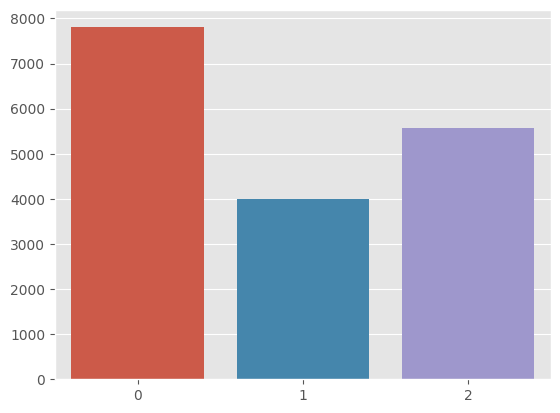

In [50]:
bias_vals = df['bias'].value_counts()
plt.figure()
sns.barplot(x=bias_vals.index, y=bias_vals.values)
plt.show();

In [56]:
def clean(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = text.replace('„','')
    text = text.replace('“','')
    text = text.replace('"','')
    text = text.replace('\'','')
    text = text.replace('-','')
    text = text.lower()
    return text
def remove_stopwords(content):
    for word in stop:
        content = content.replace(' '+word+' ',' ')
    return content
df['text'] = df['text'].apply(clean)
df['text'] = df['text'].apply(remove_stopwords)

In [58]:
train, test = train_test_split(df, test_size=0.2)

Now we take each of the train and test sets and tokenize them. 
First a function that tokenizes the text by first using the nltk.sent_tokenize() function to split the text into sentences and then the nltk.word_tokenize() function to split each sentence into words. 
Also checks if the length of each word is less than 3, and if it is, it skips that word. And then it appends the lower-cased word to a list of tokens.

The function is then applied to the train and test dataframes. For each row in the dataframe, the resulting tokens are passed as the words argument to the TaggedDocument() constructor along with the corresponding bias label. The resulting TaggedDocument objects are collected in a list and stored in the train_tagged and test_tagged variables. These TaggedDocument objects are used as input to train the Doc2Vec model, where each document in the dataset is represented by a unique vector.

In [61]:
 def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 3:
                continue
            tokens.append(word.lower())
    return tokens
train_tagged = train.apply(
   lambda r: TaggedDocument(words=tokenize_text(r['text']), tags= [r.bias]), axis=1)
test_tagged = test.apply(
   lambda r: TaggedDocument(words=tokenize_text(r['text']), tags=[r.bias]), axis=1)

## Doc2Vec Feature Vector Generation 
The Doc2Vec algorithms encodes a whole document of text into a vector of the size we choose, as opposed to individual words. The Doc2Vec vectors are able to represent the theme or overall meaning of a document. It uses the word similarities learned during training to construct a vector that will predict the words in a new document.

In [63]:
cores = multiprocessing.cpu_count()
model = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, sample=0, min_count=2, workers=cores)

In [66]:
model.build_vocab(train_tagged.values)
model.train(utils.shuffle(train_tagged.values),
total_examples=len(train_tagged.values),epochs=30)

model.save("doc2vec_articles.model")

Now I want a function which takes in a trained Doc2Vec model and the set of tagged documents to create two arrays, classes and features.

For each tagged document in sents, the code will call model.infer_vector() method to generate a feature vector for that document. The feature vector is then added to the features array, and the class label for the document (i.e. the bias in this case) is added to the classes array.

In [70]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    classes, features = zip(*[(doc.tags[0], model.infer_vector(doc.words)) for doc in sents])
    return features, classes
# PV_DBOW encoded text
train_x, train_y = vec_for_learning(model, train_tagged)
test_x, test_y = vec_for_learning(model, test_tagged)

## Classification Models 

In [71]:
from sklearn.naive_bayes import GaussianNB

In [72]:
bayes = GaussianNB()
bayes.fit(train_x,train_y)

def acc(true, pred):
  acc = 0
  for x,y in zip(true,pred):
    if(x == y): acc += 1
  return acc/len(pred)
print(acc(test_y,bayes.predict(test_x)))


0.6651310106536136


In [73]:
from sklearn.ensemble import RandomForestClassifier


In [74]:
forest = RandomForestClassifier(n_estimators=50)
forest.fit(train_x,train_y)
print(acc(test_y,forest.predict(test_x)))


0.6553412035704003


In [75]:
from sklearn.svm import SVC


In [77]:
svc = SVC()

svc.fit(train_x,train_y)
print(acc(test_y,svc.predict(test_x)))

0.7898070832133602


Since the Support Vector classifier has the best results on the test data set, we will use this to predict the biases for the subreddit texts.

Let's create a new column for label, which will be necessary for the tagging process, and also for generating the final predictions.

In [92]:
data['Label'] = 0


In [93]:
data_tagged = data.apply(lambda r: TaggedDocument(words=tokenize_text(r['cleaned']), tags=[r.Label]), axis=1)


In [96]:
data_tagged.dtype

dtype('O')

In [97]:
test_x_data, test_y_data = vec_for_learning(model, data_tagged)


In [98]:
bias = svc.predict(test_x_data)


In [100]:
bias.mean()

0.756294058408862

In [101]:
data['Label'] = bias
data.head()

,id,subreddit,title,selftext,upvote_ratio,ups,downs,score,link_flair_css_class,created_utc,kind,cleaned,Label
0,1,politics,Trump Jokes About How Longtime Aide Could End ...,,1.00,3,0,3,None,2024-04-12T09:54:31Z,t3,trump jokes longtime aide end career flash,0
1,2,politics,US to probe if Chinese cars pose national data...,,1.00,4,0,4,None,2024-04-12T09:41:11Z,t3,us probe chinese cars pose national data secur...,2
2,3,politics,Irish taoiseach and Spanish PM to discuss Pale...,,0.54,1,0,1,None,2024-04-12T09:09:41Z,t3,irish taoiseach spanish pm discuss palestine n...,0
3,4,politics,Why Trump’s ‘hush money’ case is bigger than h...,,0.94,15,0,15,None,2024-04-12T09:01:51Z,t3,trump’s ‘hush money’ case bigger hush money,0
4,5,politics,1864 AZ Speaker of the house who helped pass t...,,0.86,35,0,35,None,2024-04-12T08:20:41Z,t3,1864 az speaker house helped pass abortion law...,0


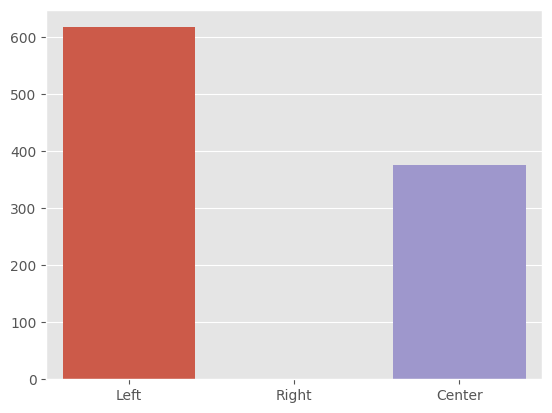

In [103]:
bias_vals = data['Label'].value_counts()
plt.figure()
sns.barplot(x=bias_vals.index, y=bias_vals.values)
tick_labels = ['Left', 'Center', 'Right']
plt.xticks(bias_vals.index, tick_labels)
plt.show()